# **Projeto: Sistema de Recomendação de Produtos da Amazon**

# **Pontos: 40**


Bem-vindo(a) ao projeto sobre sistemas de recomendação. Trabalharemos com o conjunto de dados de notas atribuídas a produtos da Amazon neste projeto. O conjunto de dados contém as notas atribuídas a diferentes produtos eletrônicos. Ele não inclui informações sobre os produtos ou avaliações para evitar que haja viés durante a construção do modelo.

--------------
## **Contexto:**
--------------

Atualmente, a informação está crescendo exponencialmente em volume, velocidade e variedade em todo o mundo. Isso tem levado a uma sobrecarga de informações e a muitas opções para o consumidor de qualquer empresa. Isso representa um verdadeiro dilema para esses consumidores, e eles frequentemente recorrem à negação. Os sistemas de recomendação são uma das melhores ferramentas que ajudam a recomendar produtos aos consumidores enquanto eles navegam on-line. Fornecer recomendações personalizadas, que sejam mais relevantes para os usuários, é o que tem mais chance de mantê-los engajados e ajudar a empresa.

Sites de e-commerce, como Amazon, Walmart, Target e Etsy, usam diferentes modelos de recomendação para fornecer sugestões personalizadas para diferentes usuários. Essas empresas gastam milhões de dólares para elaborar técnicas algorítmicas que possam fornecer recomendações personalizadas a seus usuários.

A Amazon, por exemplo, é conhecida por sua seleção acurada de recomendações em seu site on-line. O sistema de recomendação da Amazon é capaz de analisar e prever de forma inteligente as preferências de compra dos clientes para oferecer a eles uma lista de produtos recomendados. O algoritmo de recomendação da Amazon é, portanto, um elemento essencial no uso da IA para melhorar a personalização de seu site. Por exemplo, um dos modelos de recomendação padrão que a Amazon utiliza é o de filtragem colaborativa item-item, que escala para conjuntos de dados massivos e produz recomendações de alta qualidade em tempo real.

----------------
## **Objetivo:**
----------------

Você é o gerente de ciência de dados da Amazon e recebeu a tarefa de criar um sistema de recomendação para recomendar produtos aos clientes com base nas notas que eles atribuíram a outros produtos anteriormente. Você tem uma coleção de dados rotulados de notas atribuídas a produtos da Amazon. O objetivo é extrair insights relevantes dos dados e criar um sistema de recomendação que ajude a recomendar produtos para consumidores on-line.

------------------------
## **Conjunto de dados:**
------------------------

O conjunto de dados da Amazon contém os seguintes atributos:

- **userId:** cada usuário é identificado com um id único.
- **productId:** cada produto é identificado com um id único.
- **Rating:** a nota do produto correspondente dada pelo usuário correspondente.
- **timestamp:** horário em que a nota foi atribuída. **Não usaremos esta coluna** para resolver o problema atual.

**Nota:** o código tem algumas funções definidas pelo usuário, que serão úteis ao sugerir recomendações e para medir o desempenho do modelo. Você pode usar essas funções ou criar suas próprias funções.

Às vezes, a instalação da biblioteca "Surprise", usada para criar sistemas de recomendação, gera problemas no Jupyter. Para evitar quaisquer problemas, é aconselhável utilizar o **Google Colab** neste projeto.

Começaremos montando o Google Drive no Colab.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Instalando a biblioteca "Surprise"**

In [2]:
#instalando a biblioteca surprise que possui uma implementação do KNN e SVD(que não é default no google colab)
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=2811601 sha256=554ea3ef197cefcc19480cb998c4f3936aa8589755c730ec8833bcc4e0539133
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


## **Importando as bibliotecas necessárias e visão geral do conjunto de dados**

In [3]:
# Usado para não exibir as mensagens de aviso (warnings)
import warnings
warnings.filterwarnings('ignore')

# Bibliotecas básicas de analise de dados
import numpy as np
import pandas as pd

# Bibliotecas de visualização e elaboração de graficos
import matplotlib.pyplot as plt
import seaborn as sns

# Versao do tipo dicionario que não levanta erro para os dados que serão usado para recomendação
from collections import defaultdict

# Modulo do surprise para avaliar a acurario dos modelos
from surprise import accuracy

# Biblioteca para leitura e armazenamento da matriz de interaçao com o formato user ; item ; rating
from surprise.reader import Reader
from surprise.dataset import Dataset

# Tuning do modelo
from surprise.model_selection import GridSearchCV

# Separação dos dados entre treinamento e teste
from surprise.model_selection import train_test_split

# modulo com o algoritmo KNN
from surprise.prediction_algorithms.knns import KNNBasic

# MOdulo com algoritmo para fatoração de matrizes SVD
from surprise.prediction_algorithms.matrix_factorization import SVD

# Validação cruzada usando K-Fold
from surprise.model_selection import KFold

### **Carregando os dados**
- Importe o conjunto de dados.
- Adicione os nomes das colunas ['user_id', 'prod_id', 'rating', 'timestamp'].
- Descarte a coluna de timestamp.
- Copie os dados para outro DataFrame, chamado **df**.

In [4]:
# Import the dataset
df_eletronics = pd.read_csv('/content/drive/MyDrive/MIT/recommendation systems/Projeto/ratings_Electronics.csv', names=['user_id', 'item_id', 'rating', 'timestamp'])


Descartando a coluna timestamp que não faz parte da matriz de interação usuario produto

In [5]:
df_eletronics = df_eletronics.drop('timestamp', axis=1)

**Verificando as informações que foram carregadas**

In [6]:
df_eletronics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  object 
 1   item_id  object 
 2   rating   float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


Existem **7,824,482** (~ 7.8 milhões) de registros

**Como este conjunto de dados é muito extenso, tendo 7 824 482 observações, não é computacionalmente possível criar um modelo com ele. Além disso, muitos usuários atribuíram nota apenas a alguns produtos, e alguns produtos tiveram notas atribuídas por pouquíssimos usuários. Logo, podemos reduzir o conjunto de dados considerando certas suposições lógicas.**

Neste caso, consideraremos os usuários que atribuíram pelo menos 50 notas (ratings) e os produtos que têm pelo menos cinco notas (ratings) atribuídas, uma vez que, ao comprar on-line, preferimos ter um certo número de avaliações (notas) atribuídas a um produto.

Montando dicionario para usuario e quantidade de avaliações  para remover os usuários com menos de 50 avaliações

In [7]:
users = df_eletronics.user_id
# Criando um dicionario que tera para cada usuario o número de matriz_finals
ratings_count = dict()
for user in users:
    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1
    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [8]:
# Limitando o corte para 50 notas.
RATINGS_CUTOFF = 50

RATINGS_CUTOFF = 50
remove_users = []
for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)
rating = df_eletronics.loc[~df_eletronics.user_id.isin(remove_users)]

Montando dicionario para item e quantidade de avaliações por item para remover os items com menos de 5 avaliações

---



In [9]:
#Criando dicionario para os items
items = rating.item_id
# Create a dictionary from users to their number of ratings
ratings_count = dict()
for item in items:
    # If we already have the user, just add 1 to their rating count
    if item in ratings_count:
        ratings_count[item] += 1
    # Otherwise, set their rating count to 1
    else:
        ratings_count[item] = 1

In [10]:
RATINGS_CUTOFF = 5
remove_items = []
for item, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_items.append(item)
rating = rating.loc[~rating.item_id.isin(remove_items)]

In [11]:
rating.shape

(65290, 3)

O conjunto de dados final após os filtros de usuarios com pelo menos 50 avaliações e items com pelo menos 5 avaliações ficou com **65290 registros**.

Analisando as 10 primeiras linhas do conjunto de dados após os filtros


In [12]:
rating.head(10)

,user_id,item_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0
1485,A19N3S7CBSU6O7,1400501466,5.0
2082,A2ZR3YTMEEIIZ4,1400532655,5.0
2150,A3CLWR1UUZT6TG,1400532655,5.0
2162,A5JLAU2ARJ0BO,1400532655,1.0
2228,A1P4XD7IORSEFN,1400532655,4.0


## **Análise Exploratória dos Dados**

### **Forma dos dados**

### **Verifique o número de linhas e colunas e forneça observações.**

In [13]:
rating.shape

(65290, 3)

A conjunto de dados possui **65290 registros** e 3 colunas seindi user_id (com o Id do usuário), item_id(id_item avaliado) e rating com a avaliação.

### **Tipos de dados**

In [14]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65290 entries, 1310 to 7824427
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   item_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


**O conjunto de dados possui 3 colunas:**
- 2 colunas do tipo object que possui os identificadores do usuario (user_id) e item (item_id)
- 1 coluna do tipo decimal (float64) para armazenar os ratings

### **Verificação de valores ausentes**

In [15]:
# Check for missing values present and provide observations
rating.isna().sum()

user_id    0
item_id    0
rating     0
dtype: int64

**Não existem valores ausentes na matriz**

### **Resumo das estatísticas**

In [16]:
rating.describe(include="all").T


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
user_id,65290,1540,ADLVFFE4VBT8,295,NaN,NaN,NaN,NaN,NaN,NaN,NaN
item_id,65290,5689,B0088CJT4U,206,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rating,65290.0,NaN,NaN,NaN,4.294808,0.988915,1.0,4.0,5.0,5.0,5.0


**Análise das estatísticas:**
- Existem 1540 usuários únicos, sendo que o usuário **ADLVFFE4VBT8** possui o maior volume de avaliações.
- Existem 5689 items únicos, sendo o item **B0088CJT4U** com maior volume de avaliações.
- A nota mínima é 1, a nota máxima é 5. Média das avaliações de 4.3.  

### **Verificando a distribuição das notas atribuídas**

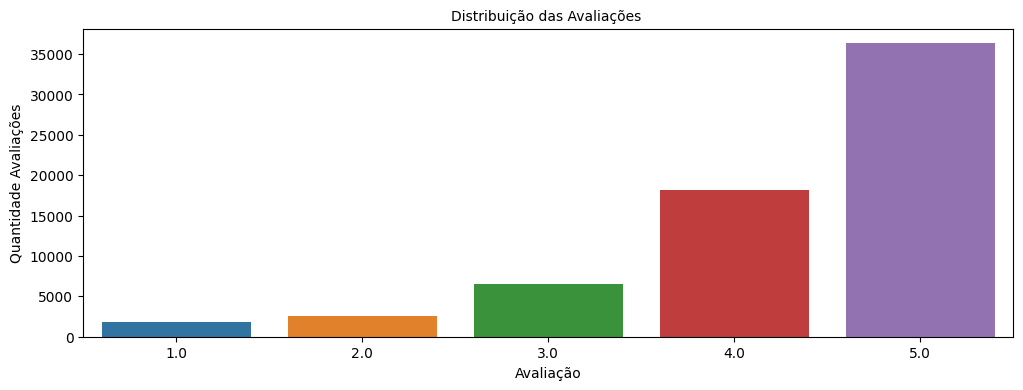

In [17]:
plt.figure(figsize = (12, 4))
sns.countplot(x="rating", data=rating)

plt.tick_params(labelsize = 10)
plt.title("Distribuição das Avaliações ", fontsize = 10)
plt.xlabel("Avaliação", fontsize = 10)
plt.ylabel("Quantidade Avaliações", fontsize = 10)
plt.ticklabel_format(useOffset=False, style='plain', axis='y')
plt.show()

Tabela com a distribuição das avaliações:

In [18]:
rating["rating"].value_counts()

5.0    36315
4.0    18127
3.0     6481
2.0     2515
1.0     1852
Name: rating, dtype: int64

Percentual de distribuição das avaliações

In [19]:
rating["rating"].value_counts(normalize=True)

5.0    0.556211
4.0    0.277638
3.0    0.099265
2.0    0.038520
1.0    0.028366
Name: rating, dtype: float64

**Análises:**
- A Avaliação 5 possui a maior ocorrência  36315 registros (~55.6%)
- A avaliação 4 vem em 2o lugar com 18127 registros (~27.7%)
- As avaliações 4 e 5 juntas correspondem por **~83.3%** das avaliações, e o restante (1,2,3) em apenas **~16.7%**, mostrando uma tendência dos usuarios de atribuir 4 ou 5.  

### **Verificando o número de usuários e itens únicos no conjunto de dados**

In [20]:
items_distintos=rating['item_id'].nunique()
print(f"Total de items distintos:{items_distintos}")
user_distintos=rating['user_id'].nunique()
print(f"Total de usuários distintos:{user_distintos}")
print("Total de possibilidades:",items_distintos*user_distintos)

Total de items distintos:5689
Total de usuários distintos:1540
Total de possibilidades: 8761060


**Análise:**
- Existem **5689 items** distintos
- Existem **1540 usuários** distintos
- Multiplicando 5689x1540 temos **8761060 possibilidades**, mas a matriz filtrada possui apenas 6529, ou seja existe um volume bem grande de pares (usuario,item) sem classificação na matriz filtrada.   


### **Usuários com o maior número de notas atribuídas**

In [21]:
# Top 10 users based on the number of ratings
rating.groupby("user_id")["rating"].count().sort_values(ascending=False).head(10)

user_id
ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A22CW0ZHY3NJH8    193
A1UQBFCERIP7VJ    193
AWPODHOB4GFWL     184
A3LGT6UZL99IW1    179
Name: rating, dtype: int64

Importante destacar que o ranking esta sendo montado sobre a base filtrada, com isso ele pode ser diferente se aplicado a base com a matriz completa.<br>
Usuário com maior números de avaliações: **ADLVFFE4VBT8**, com 295.

**Agora que exploramos e preparamos os dados, criaremos o primeiro sistema de recomendação.**

## **Modelo 1: Sistema de Recomendação Baseado em Classificação**

**Montando sistema de recomendação baseado em popularidade.**

Calculando a média por item e a quantidade de avaliações obtidas por item

In [22]:
# Calculating average ratings
average_rating = rating.groupby('item_id')['rating'].mean()

# Calculating the count of ratings
count_rating = rating.groupby('item_id')['rating'].count()

# Making a dataframe with the count and average of ratings
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})


Gerando o Data Frame com os items ordenados pela média e pela quantidade de avalialções:

In [23]:
# Ordenando pela avaliação media e pelo total de avaliações
final_rating.sort_values(by=["avg_rating","rating_count"],ascending=False,inplace=True)
final_rating.head(15)


,avg_rating,rating_count
item_id,,
B000FQ2JLW,5.0,19
B00ISFNSBW,5.0,18
B000IJY8DS,5.0,17
B001TH7GUA,5.0,17
B00HZWJGS8,5.0,17
B005LDLP8W,5.0,16
B00HG1L334,5.0,16
B0012Y6HC8,5.0,15
B0033PRWSW,5.0,15


O item B000FQ2JLW deve média 5 com o maior quantidade de avaliações 19.

### **Recomendando os cinco principais produtos com, no mínimo, 50 interações com base na popularidade**

Criando uma função para listar o ranking dos principais items com base na popularidade.

In [24]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def top_n_items(dados,num,min_iter):
    # Identificando os items com numero de interações superior ao min
    rec = dados[dados['rating_count'] >= min_iter]
    # Sorting values w.r.t average rating
    rec = rec.sort_values(by='avg_rating', ascending=False)
    return rec.index[:num]

Listando o ranking dos 5 items mais populares que tiveram pelo menos 50 iterações

In [25]:
top_n_items(final_rating,5,50)

Index(['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW'], dtype='object', name='item_id')

### **Recomendando os cinco principais produtos com, no mínimo, 100 interações com base na popularidade**

In [26]:
top_n_items(final_rating,5,100)

Index(['B003ES5ZUU', 'B000N99BBC', 'B002WE6D44', 'B007WTAJTO', 'B002V88HFE'], dtype='object', name='item_id')

 Foram gerados os **cinco principais** produtos usando o sistema de recomendação de popularidade com mínimo de 50 e 100 interações. Agora, criaremos um sistema de recomendação usando a **filtragem colaborativa.**

## **Modelo 2: Sistema de Recomendação de Filtragem Colaborativa**

### **Criando um sistema de recomendação de referência baseado em similaridade usuário-usuário**

- Abaixo, estamos criando **sistemas de recomendação baseados em similaridade**, usando a similaridade `cosine` (cosseno), e utilizando o **KNN para encontrar usuários semelhantes**, que são os vizinhos mais próximos do usuário em questão.
- Usaremos uma nova biblioteca, chamada `surprise`, para criar os demais modelos. Primeiro, importaremos as classes e funções necessárias dessa biblioteca.

In [27]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Antes de criarmos os sistemas de recomendação, revisaremos algumas terminologias básicas que usaremos:**

**Item relevante:** um item (produto, neste caso) cuja **avaliação real é maior que a avaliação de referência (limite)** é considerado relevante. Se a **avaliação real estiver abaixo da referência, então o item é considerado não relevante**.

**Item recomendado:** um item cuja **avaliação prevista é maior que a avaliação de referência é considerado um item recomendado**. Se a **avaliação prevista estiver abaixo da referência, tal produto não será recomendado ao usuário**.

**Falso negativo (FN):** é a **frequência de itens relevantes que não são recomendados ao usuário**. Se os itens relevantes não forem recomendados ao usuário, é possível que o usuário não compre o produto/item. Isso resultaria em **perda de oportunidade para o prestador do serviço**, algo que ele gostaria de minimizar.

**Falso positivo (FP):** é a **frequência de itens recomendados que, na verdade, não são relevantes**. Nesse caso, o sistema de recomendação não está fazendo um bom trabalho no que diz respeito à localização e recomendação de itens relevantes para o usuário. Isso resultaria em **perda de recursos para o prestador do serviço**, algo que ele também gostaria de minimizar.

**Recall:** é a **fração de itens realmente relevantes que são recomendados ao usuário**. Por exemplo, se de dez produtos relevantes, seis são recomendados para o usuário, o recall é de 0.6. Quanto maior é o valor do recall, melhor é o modelo. É uma das métricas usadas para avaliar o desempenho dos modelos de classificação.

**Precisão:** é a **fração de itens recomendados que são realmente relevantes**. Por exemplo, se de dez itens recomendados, seis são considerados relevantes pelo usuário, a precisão é de 0.6. Quanto maior é o valor da precisão, melhor é o modelo. É uma das métricas usadas para avaliar o desempenho dos modelos de classificação.

**Ao criar um sistema de recomendação, costuma-se observar o desempenho do modelo. Em termos de quantas recomendações são relevantes, e vice-versa, abaixo estão algumas das métricas de desempenho mais usadas na avaliação de sistemas de recomendação.**

### **Precision@k, Recall@k e F1-score@k**

**Precision@k**: é a **fração de itens recomendados que são relevantes nas `top k` (k principais) previsões**. O valor de k é o número de recomendações a serem fornecidas ao usuário. Pode-se escolher um número variável de recomendações a serem fornecidas a um único usuário.


**Recall@k**: é a **fração de itens relevantes que são recomendados ao usuário nas `top k` (k principais) previsões**.

**F1-score@k**: é a **média harmônica de Precision@k e Recall@k**. Quando **tanto precision@k quanto recall@k parecem ser importantes**, é útil usar essa métrica, pois é representativa de ambas.

### **Algumas funções úteis**

- A função abaixo recebe o **modelo de recomendação** como entrada e fornece **precision@k, recall@k e F1-score@k** para esse modelo.
- Para calcular a **precisão** e o **recall**, as **k principais** previsões são consideradas para cada usuário.
- Usaremos a precisão e o recall para calcular o F1-score.

In [28]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)


    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Dicas:**

- Para calcular a **precisão** e o **recall**, uma **referência de 3.5 e um valor de k igual a 10 podem ser considerados para as avaliações recomendadas e relevantes**.
- Pense na métrica de desempenho a ser escolhida.

Abaixo, estamos carregando o **conjunto de dados de** **`rating`**, que é um **DataFrame do pandas**, em um **formato diferente chamado `surprise.dataset.DatasetAutoFolds`**, que é exigido por essa biblioteca. Para isso, **utilizaremos as classes `Reader` e `Dataset`.**.<br>
Além disso, foi feita a divisão do conjunto de dasos entre treinamento e testes.

In [29]:
#Instanciando o Reader com a escalada de rating
reader = Reader(rating_scale=(0, 5))
# Lendo dataset
data = Dataset.load_from_df(rating[['user_id', 'item_id', 'rating']], reader)
# Gerando os dados de treinamento e testes
trainset, testset = train_test_split(data, test_size=0.7, random_state=42)

Agora, estamos **prontos para criar o primeiro sistema de recomendação de referência baseado em similaridade** usando a similaridade de cosseno.

### **Criando o Sistema de Recomendação Baseado em Similaridade Usuário-Usuário**

In [30]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': True}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
algo_knn_user = KNNBasic(sim_options=sim_options,verbose=False,random_state=1)

# Fit the model on the training data
algo_knn_user.fit(trainset)
predictions = algo_knn_user.test(testset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
#print(accuracy.rmse(predictions))
#print(accuracy.mae(predictions))
precision_recall_at_k(algo_knn_user)


RMSE: 1.0552
Precision:  0.855
Recall:  0.48
F_1 score:  0.615


Para um limite de **3.5** (avaliação de referencia) e K=10  temos:
- O  RMSE que indica  distância entre as classificações gerais previstas e as classificações reais de **1.0552**.<br>
-**Precisão**: Modelo gerou  uma precisão de quase 0.855 , o que significa que de todos os items recomendados **85.5% são relevantes** para um .
-**Recall**:Modelo esta com um  recall de quase 0,48, o que significa que de todos os items relevantes, **48% são recomendados**.
- F1 Score:  O modelo esta com F1 Score de  **0,615**.

Agora, **preveremos a avaliação para o usuário com `userId=A3LDPF5FMB782Z` e o `productId=1400501466`**, conforme mostrado abaixo. Neste caso, o usuário já interagiu ou viu o produto com productId "1400501466" e atribuiu uma nota 5.

In [31]:
# Predicting rating for a sample user with an interacted product
algo_knn_user.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.291366722826364, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

A avaliação real para este par de item e usuário é 5 e a avaliação prevista é 4.29.Pelo limite de 3.5 estabelecido, este item que é relevante poderia ser recomentado.



Abaixo, está a **lista de usuários que não viram o produto com productId "1400501466"**.

In [32]:
# Find unique user_id where prod_id is not equal to "1400501466"
#Gerando a lista dos usuários que não viram o item
n_viu_item=rating[rating.item_id != "1400501466"].user_id.unique()
print(n_viu_item)


['A2ZR3YTMEEIIZ4' 'A3CLWR1UUZT6TG' 'A5JLAU2ARJ0BO' ... 'A215WH6RUDUCMP'
 'A38C12950IM24P' 'A2J4XMWKR8PPD0']


Confirmando que o usuário A34BZM6S9L7QI4 não viu o iten en questão:

In [33]:
#Confirmando que o usuário A34BZM6S9L7QI4 não viu o item
np.isin("A34BZM6S9L7QI4",n_viu_item)

array(True)

* Pode-se observar na lista acima que **o usuário "A34BZM6S9L7QI4" não viu o produto com productId "1400501466"**, pois esse userId faz parte da lista acima.

**Abaixo, estamos prevendo a avaliação/nota para `userId=A34BZM6S9L7QI4` e `prod_id=1400501466`.**

In [34]:
# Predicting rating for a sample user with a non interacted product
algo_knn_user.predict("A34BZM6S9L7QI4","1400501466",verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.291366722826364, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

A estimativa para esse usuário seria de 4.29.

### **Melhorando o sistema de recomendação baseado em similaridade ajustando seus hiperparâmetros**

Abaixo, estaremos ajustando hiperparâmetros para o algoritmo `KNNBasic`. Vamos entender alguns dos hiperparâmetros do algoritmo KNNBasic:

- **k** (int): o número (máximo) de vizinhos a serem considerados para agregação. O padrão é 40.
- **min_k** (int): o número mínimo de vizinhos a serem considerados para agregação. Se não houver vizinhos suficientes, a previsão é definida como a média global de todas as avaliações (notas). O padrão é 1.
- **sim_options** (dict): um dicionário de opções para a medida de similaridade. E há quatro medidas de similaridade disponíveis em Surprise:
    - cosseno
    - msd (distância média quadrática, padrão)
    - Pearson
    - baseline de Pearson

In [35]:

param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['cosine',"pearson","msd","pearson_baseline"],
                              'user_based': [True]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse','mae'], cv=3, n_jobs=-1)

# Fitting the data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9707809546144164
{'k': 40, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


De acordo com  o processo de otimização para o modelo de recomendação baseado em usuário, os parametros seriam:<br>
K=40<br>
min_k=6<br>
Medida distância: coseno.

Assim que a busca em grade (grid search) estiver **concluída**, podemos obter os **valores ideais para cada um desses hiperparâmetros**.

Agora, criaremos o **modelo final usando os valores ajustados dos hiperparâmetros** que recebemos usando a **busca em grade com validação cruzada**.

In [36]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'cosine',
               'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized_user = KNNBasic(sim_options=sim_options, k=40, min_k=6,Verbose=False)

# Training the algorithm on the trainset
similarity_algo_optimized_user.fit(trainset)

# Predicting ratings for the testset
predictions = similarity_algo_optimized_user.test(testset)

# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(similarity_algo_optimized_user)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9887
Precision:  0.832
Recall:  0.472
F_1 score:  0.602


- Houve uma melhora no RMSE, que foi a métrica utilizada para os ajustes de hiper-parametros,   de 1.05 para 0.98.

### **Passos:**
- **Prever a nota para o usuário com `userId="A3LDPF5FMB782Z"` e o `prod_id= "1400501466"` usando o modelo otimizado.**
- **Prever a nota para o usuário com `userId="A34BZM6S9L7QI4"`, que não interagiu com o `prod_id ="1400501466"`, usando o modelo otimizado.**
- **Comparar a saída com a saída do modelo de referência.**

In [54]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
similarity_algo_optimized_user.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)


user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.291366722826364, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [55]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
similarity_algo_optimized_user.predict("A34BZM6S9L7QI4","1400501466",verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.291366722826364, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})


- para o usuário com userId="A3LDPF5FMB782Z" e o prod_id= "1400501466",  a estimativa foi de 4.29.
- Para o usuário com userId="A34BZM6S9L7QI4", que não interagiu com o prod_id ="1400501466", a estimativa foi de 4.29.
- Para ambos os casos o produto seria recomendado.
- Tanto o modelo base, quanto o modelo otimizado calcularam os mesmos valores de rating para os dois casos.


### **Identificando usuários semelhantes a um determinado usuário (vizinhos mais próximos)**

Também podemos descobrir **usuários semelhantes a um determinado usuário** ou seus **vizinhos mais próximos** com base neste algoritmo KNNBasic. Abaixo, encontramos os cinco usuários mais semelhantes ao primeiro usuário da lista com id interno 0, com base na métrica de distância `msd`.

In [53]:
# 0 is the inner id of the above user
similarity_algo_optimized_user.get_neighbors(0, 5)

[7, 12, 14, 23, 47]

### **Implementação do algoritmo de recomendação baseado no modelo KNNBasic otimizado**

Abaixo, implementaremos uma função, na qual os parâmetros de entrada são:

- data: conjunto de dados de avaliações/notas (**rating**).
- user_id: id do usuário **em relação ao qual desejamos as recomendações**.
- top_n: **número de produtos que queremos recomendar**.
- algo: algoritmo que queremos usar **para prever as avaliações/notas**.
- A saída da função é um **conjunto de top_n itens** recomendado para o dado user_id com base no algoritmo fornecido.

In [51]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'item_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Prevendo os cinco principais produtos para o userId = "A3LDPF5FMB782Z" com sistema de recomendação baseado em similaridade**

In [52]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations = get_recommendations(rating, "A3LDPF5FMB782Z", 5, similarity_algo_optimized_user)
pd.DataFrame(recommendations, columns = ['item_id', 'predicted_ratings'])

,item_id,predicted_ratings
0,1400532655,4.291367
1,1400599997,4.291367
2,9983891212,4.291367
3,B00000DM9W,4.291367
4,B00000J1V5,4.291367


Foi possível prever os 5 principais produtos para o usuário A3LDPF5FMB782Z utilizando o algorítmo de similaridade usuário-usuário.


### **Sistema de Recomendação de Filtragem Colaborativa Baseada em Similaridade Item-Item**

* Acima, vimos a **filtragem colaborativa baseada em similaridade**, na qual a similaridade é calculada **entre usuários**. Agora, analisaremos a filtragem colaborativa baseada em similaridade, na qual a similaridade é examinada **entre os itens**.

In [37]:
# Definfing similarity measure
sim_options = {'name': 'cosine',
               'user_based': False}

# Defining Nearest neighbour algorithm
algo_knn_item = KNNBasic(sim_options=sim_options,verbose=False)

# Train the algorithm on the trainset or fitting the model on train dataset
algo_knn_item.fit(trainset)

# Predict ratings for the testset
predictions = algo_knn_item.test(testset)

# Then compute RMSE

precision_recall_at_k(algo_knn_item)

RMSE: 1.0697
Precision:  0.833
Recall:  0.472
F_1 score:  0.603


Para um limite de **3.5** (avaliação de referencia) e K=10  temos:
- O  RMSE indica  distância entre as classificações gerais previstas e as classificações reais de **1.0697**.<br>
-**Precisão** - Modelo gerou  uma precisão de quase 0.833 , o que significa que de todos os items recomendados **83.3% são relevantes** .
-**Recall**:Modelo esta com um  recall de quase 0,472, o que significa que dos items relevantes, **47.2% são recomendados**.
- F1 Score:  O modelo esta com F1 Score de  **0,603**.
- O modelo base utilizando similaridade item-item esta com métricas um pouco piores que o modelo usuário-usuário (RMSE de 1.067 contra um RMSE de 1.0552 do modelo base de similaridade usuário-usuário.

Agora, **preveremos uma avaliação/nota para o usuário com `userId = A3LDPF5FMB782Z` e o `prod_Id = 1400501466`**, conforme mostrado abaixo. Neste caso, o usuário já interagiu ou viu o produto com productId "1400501466".

Confirmando a nota real que o usuário deu ao item:

In [38]:
rating[(rating["item_id"]=="1400501466") & (rating["user_id"]=="A3LDPF5FMB782Z")]

,user_id,item_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0


O item **400501466** recebeu nota 5 do usuário  **A3LDPF5FMB782Z**.<br>
Agora vamos verificar a nota estimada pelo modelo:

In [39]:
# Predicting rating for a sample user with an interacted product
algo_knn_item.predict("A3LDPF5FMB782Z","1400501466", r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.291366722826364, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

A avaliação real para este par de item e usuário é 5 e a avaliação prevista é 4.29. Como a nota de corte sendo utilizada é 3.5, este item que é relevante poderia ser recomendado para o usuario.

Abaixo, estamos **prevendo a avaliação/nota para o `userId = A34BZM6S9L7QI4` e o `prod_id = 1400501466`**.



In [42]:
# Predicting rating for a sample user with a non interacted product
algo_knn_item.predict("A34BZM6S9L7QI4","1400501466", verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.291366722826364, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

A nota para o produto  1400501466 que o usuário não classificou seria 4.29

Para ambos os casos o produto poderia ser recomendado, considerando o limite de 3.5.

### **Ajuste de hiperparâmetros do modelo baseado em similaridade item-item**
- Use os seguintes valores para a grade de parâmetros (param_grid) e ajuste o modelo.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() para ajustar o modelo usando a medida RMSE.
- Imprima o melhor escore e os melhores parâmetros.

In [44]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20,30], 'min_k': [3,6,9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
grid_met=[]

grid_met = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3,n_jobs=1,joblib_verbose=False)

# Fitting the data
grid_met.fit(data)

# Best RMSE score}
print(grid_met.best_score['rmse'])


# Combination of parameters that gave the best RMSE score
print(grid_met.best_params['rmse'])


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matr

De acordo com  o processo de otimização para o modelo de recomendação baseado em usuário, os parametros seriam:<br>
K=30<br>
min_k=6<br>
Medida distância: msd.

Assim que a **busca em grade (grid search)** estiver concluída, podemos obter os **valores ideais para cada um desses hiperparâmetros, conforme mostrado acima**.

Agora, criaremos o **modelo final** usando os **valores ajustados dos hiperparâmetros** que recebemos usando a **busca em grade com validação cruzada**.

### **Use os melhores parâmetros do GridSearchCV para criar o modelo baseado em similaridade item-item otimizado. Compare o desempenho do modelo otimizado com o do modelo de referência.**

In [45]:
# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized_item = KNNBasic(sim_options={'name': 'msd', 'user_based': False}, k=30, min_k=6,verbose=False)

# Training the algorithm on the trainset
similarity_algo_optimized_item.fit(trainset)

# Predicting ratings for the testset
predictions = similarity_algo_optimized_item.test(testset)

# Computing RMSE on testset
precision_recall_at_k(similarity_algo_optimized_item)

RMSE: 0.9896
Precision:  0.829
Recall:  0.471
F_1 score:  0.601


- Houve uma melhora do RMSE, que foi a métrica utilizada para otimização dos hiper-parametros de **1.06** para **0.98**
- Precisão: dos items recomendados **82.9%** são relevantes.
- Recall: dos itens relevantes **47.1%** estão sendo recomendados.    
- Importante destacar que houve uma pequena variação (piora) nos parametros de Precision, de Recall e F1_score.


### **Passos:**
- **Prever a avaliação/nota para o usuário com `userId="A3LDPF5FMB782Z"` e o `prod_id= "1400501466"` usando o modelo otimizado.**
- **Prever a avaliação/nota para o usuário com `userId="A34BZM6S9L7QI4"`, que não interagiu com o `prod_id ="1400501466"`, usando o modelo otimizado.**
- **Comparar a saída com a saída do modelo de referência.**

In [47]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
similarity_algo_optimized_item.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)


user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.291366722826364, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

Se compararmos a avaliação prevista acima, podemos ver a avaliação prevista do modelo base como 4.29 e o modelo otimizado previu a mesma classificação de 4.29. Considerando que a avaliação real é 5.0.

In [48]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
similarity_algo_optimized_item.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.291366722826364, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

O modelo otimizado está prevendo uma nota de avaliação de 4.29 para o item que não foi avaliado pelo usuário.

Tanto o modelo base quanto o modelo otimizado iriam recomendar os produtos acima, com base no linite de 3.5.

### **Identificando itens semelhantes a um determinado item (vizinhos mais próximos)**

Também podemos descobrir **itens semelhantes** a um determinado item ou seus vizinhos mais próximos com base neste **algoritmo KNNBasic**. Abaixo, encontramos os cinco itens mais semelhantes ao item com id interno 0, com base na métrica de distância `msd`.

In [49]:
similarity_algo_optimized_item.get_neighbors(0, k=5)

[151, 760, 841, 874, 969]

**Previsão dos cinco principais produtos para o userId = "A1A5KUIIIHFF4U" com o sistema de recomendação baseado em similaridade.**

**Dica:** use a função get_recommendations().

In [56]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations = get_recommendations(rating, "A1A5KUIIIHFF4U", 5, similarity_algo_optimized_item)
pd.DataFrame(recommendations, columns = ['item_id', 'predicted_ratings'])

,item_id,predicted_ratings
0,1400532655,4.291367
1,1400599997,4.291367
2,9983891212,4.291367
3,B00000DM9W,4.291367
4,B00000J1V5,4.291367


Foi possível prever os 5 principais items para o usuário A1A5KUIIIHFF4U utilizando o algorítmo de similaridade usuário-usuário.

Agora, como vimos **algoritmos de filtragem colaborativa baseados em similaridade**, trataremos de **algoritmos de filtragem colaborativa baseados em modelo**.

### **Modelo 3: Filtragem Colaborativa Baseada em Modelo: Fatoração de Matrizes**

A Filtragem Colaborativa Baseada em Modelo é um **sistema de recomendação personalizado**. As recomendações são baseadas no comportamento passado do usuário e não dependem de informações adicionais. Usamos **recursos latentes** para encontrar recomendações para cada usuário.

### Decomposição em Valores Singulares (SVD)

SVD é usado para **computar os recursos latentes** da **matriz item-usuário**, mas não funciona quando **há valores ausentes** na **matriz item-usuário**.

In [58]:
# Using SVD matrix factorization
algo_svd = SVD()

# Training the algorithm on the trainset
algo_svd.fit(trainset)

# Predicting ratings for the testset
predictions = algo_svd.test(testset)


precision_recall_at_k(algo_svd)


RMSE: 0.9304
Precision:  0.878
Recall:  0.489
F_1 score:  0.628


Para um limite de 3.5 e K=10  temos:

- O RMSE indica distância entre as classificações gerais previstas e as classificações reais de **0.93**.
- Precisão - Modelo gerou uma precisão de quase 0.877 , o que significa que de todos os items recomendados **87.8%** são relevantes.
- Recall:Modelo esta com um recall de quase 0,49, o que significa que de todos os items relevantes, **49%** são recomendados.
- F1 Score: O modelo esta com F1 Score de 0,628.
- O Modelo base de SVD esta com métricas melhores que os modelos de filtragem colaborativa.

**Agora, preveremos a avaliação/nota para o usuário com `userId = "A3LDPF5FMB782Z"` e o `prod_id = "1400501466`.**

In [59]:
# Making prediction
algo_svd.predict("A3LDPF5FMB782Z","1400501466", r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.10   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.099594268124127, details={'was_impossible': False})

Avaliação deste usuário para o item é 5, e o modelo previu 4.10.


**Abaixo, estamos prevendo a avaliação/nota para o `userId = "A34BZM6S9L7QI4"` e o `productId = "1400501466"`.**

In [ ]:
# Making prediction
algo_svd.predict("A34BZM6S9L7QI4","1400501466", verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.25   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.253835593691978, details={'was_impossible': False})

O modelo preveu uma avaliação de 4.25 para o item que o usuário não havia avaliado.

### **Melhorando o sistema de recomendação baseado em fatoração de matrizes ajustando seus hiperparâmetros**

Abaixo, ajustaremos apenas três hiperparâmetros:
- **n_epochs**: número de iterações do algoritmo SGD (Gradiente Descendente Estocástico).
- **lr_all**: taxa de aprendizado para todos os parâmetros.
- **reg_all**: termo de regularização para todos os parâmetros.
- **n_factors**= número de recursos latentes que serão utilizados no modelo

In [60]:
#from pandas.core.common import random_state
# Set the parameter space to tune
gs_svd = []
#svd_grid=SVD(random_state=1)
#param_grid = {'n_epochs': [10, 20,30], 'lr_all': [0.001, 0.005, 0.01,0.05],
#              'reg_all': [0.1,0.2, 0.4,0.6,0.8]}

gs_svd=[]
param_grid = {"n_factors":[100,150,200],'n_epochs':[ 10,20,30], 'lr_all': [0.001, 0.005, 0.01,0.05],
              'reg_all': [0.1,0.2, 0.4,0.6]}


# Performing 3-fold gridsearch cross validation
gs_svd = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting data
gs_svd.fit(data)

# Best RMSE score
print(gs_svd.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs_svd.best_params['rmse'])

0.8988323712941592
{'n_factors': 100, 'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}


Agora, **criaremos o modelo final** usando os **valores ajustados** dos hiperparâmetros que recebemos usando a validação cruzada da busca em grade acima.

In [61]:
# Building the optimized SVD model using optimal hyperparameter search
svd_algo_optimized = []

svd_algo_optimized = SVD(n_factors=100,n_epochs=20, lr_all=0.01, reg_all=0.2)

# Training the algorithm on the trainset
svd_algo_optimized.fit(trainset)

# Predicting ratings for the testset
predictions = svd_algo_optimized.test(testset)

# Computing RMSE
#accuracy.rmse(predictions)
precision_recall_at_k(svd_algo_optimized)

RMSE: 0.9228
Precision:  0.882
Recall:  0.489
F_1 score:  0.629


- Houve uma pequena melhora do RMSE, que foi a métrica utilizada para otimização dos hiper-parametros de **0.93** para **0.92**
- Precisão: dos items recomendados **88%** são relevantes.
- Recall: dos itens relevantes **48.9%** estão sendo recomendados.    
- F1_Score passou para 0.629
- As métricas estão bem semelhantes após a otimização.

### **Passos:**
- **Prever a avaliação/nota para o usuário com `userId="A3LDPF5FMB782Z"` e o `prod_id= "1400501466"` usando o modelo otimizado.**
- **Prever a avaliação/nota para o `userId="A34BZM6S9L7QI4"`, que não interagiu com `prod_id ="1400501466"`, usando o modelo otimizado.**
- **Comparar a saída com a saída do modelo de referência.**

In [63]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
svd_algo_optimized.predict("A3LDPF5FMB782Z","1400501466", r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.85   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.8542880925751675, details={'was_impossible': False})

O modelo otimizado previu uma avaliação de 3.85 enquanto o usuário havia dado uma avalição de 5, de modo que o modelo otimizado esta tendo um comportamento pior que o modelo SVD de base.


In [ ]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
svd_algo_optimized.predict("A34BZM6S9L7QI4","1400501466",  verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.07   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.0667415054698175, details={'was_impossible': False})

o modelo SVD otimizado previu uma nota de 4.07.

### **Conclusão e Recomendações**

**Conclusão**
- Os modelos colaborativos baseados em usuário e baseados em itens têm quase os mesmos valores de RMSE( baseado em similaridade de usuário é 1.05 enquanto o modelo baseado em itens é 1.06). Os modelos de filtragem colaborativa otimizados tiveram um desempenho melhor do que o modelo base (menor RMSE).
- O modelo utilizando SVD, que utiliza decomposição de matrizes e identifica variaveis latentes teve um métrica RMSE melhor 0.93, e tambem melhora nos indicadores de precisão, recall e F1_score.
- Ambos os 3 tipos de modelos **Filtragem colaborativa baseado en usuário**, **filtragem colaborativa baseado em item**, e **SVD** tiveram boas métricas de precisão (proporção dos items recomendados que são relevantes), com destaque para o modelo otimizado baseado em usuario com **83%** e para o SVD base com **88%**.    
- Como recomendação seria importante que fosse realizado um teste A/B com cada um dos modelos para medir se as recomendações de cada modelo estão se convertendo em compras para a empresa.



